<a href="https://colab.research.google.com/github/AlexeyKarz/food-models/blob/main/fast_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Food Vision using Keras and TensorFlow

During this project I will build a multiclass image classification model using Keras Functional API. For this project I used a subsed of food101 dataset. I extracted following classes from the [original dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) using [this](https://github.com/AlexeyKarz/food-models/blob/main/extra/data_extracting.ipynb) functions. I will also use some functions from this [file](https://github.com/AlexeyKarz/food-models/blob/main/extra/food_helper_functions.py) for different perposes, the original [code](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py) of some of these functions was made by ZTM. The classes are: `'chicken_wings' 'club_sandwich' 'donuts' 'french_fries' 'hamburger'
 'hot_dog' 'onion_rings' 'pizza' 'sushi' 'tacos'`

# Setting the workspace

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.14.0
Hub version: 0.15.0


In [2]:
#check available devices
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [3]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-be3a70e5-8f9a-63c3-0108-fccc51332f8e)


In [4]:
# Providing my drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import functions that might be useful during the process

In [5]:
!wget https://raw.githubusercontent.com/AlexeyKarz/food-models/main/extra/food_helper_functions.py
import food_helper_functions

--2023-11-12 11:36:03--  https://raw.githubusercontent.com/AlexeyKarz/food-models/main/extra/food_helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8540 (8.3K) [text/plain]
Saving to: ‘food_helper_functions.py’

food_helper_functio 100%[===================>]   8.34K  --.-KB/s    in 0s      

2023-11-12 11:36:03 (105 MB/s) - ‘food_helper_functions.py’ saved [8540/8540]



# Accessing the data

In [6]:
folder_path = '/content/drive/MyDrive/Projects/food101/fast_food_10_classes'


In [7]:
train_dir = "/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/"
test_dir = "/content/drive/MyDrive/Projects/food101/fast_food_10_classes/test/"

In [8]:
import os

# Walking through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(folder_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes'.
There are 10 directories and 0 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/hamburger'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/french_fries'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/hot_dog'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/donuts'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/tacos'.
There are 0 directories and 750 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes/train/pizza'.
There are 0 directories and 750 images in '/content/drive/MyDri

In [9]:
# Get the class names for our multi-class dataset
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_wings' 'club_sandwich' 'donuts' 'french_fries' 'hamburger'
 'hot_dog' 'onion_rings' 'pizza' 'sushi' 'tacos']


### Visualization - Running the notebook with helper functions

Now I want to visualize some data so I use `view_three_images()` function I imported from the `food_helper_functions` module

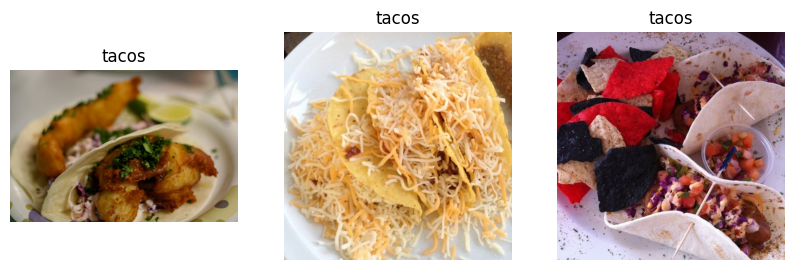

In [10]:
import random
food_helper_functions.view_three_images(target_dir=train_dir, target_class=random.choice(class_names))

# Data preprocessing

Now I have to prepare the data for the model. I will create image generators which rescale the images, create mini batches with target image size.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale the data
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# load the data and create mini batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')


Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Creating and fitting the model

First, I will create a similar model to the one I used in binary classification (TinyVGG). To create the model I will use Functional Keras API

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

input_layer = Input(shape = (224, 224, 3))

conv1 = Conv2D(10, 3, activation='relu')(input_layer)
conv2 = Conv2D(10, 3, activation='relu')(conv1)
maxpool1 = MaxPooling2D()(conv2)

conv3 = Conv2D(10, 3, activation='relu')(maxpool1)
conv4 = Conv2D(10, 3, activation='relu')(conv3)
maxpool2 = MaxPooling2D()(conv4)

flatten = Flatten()(maxpool2)

output_layer = Dense(10, activation='softmax')(flatten)

model = Model(inputs=input_layer, outputs=output_layer)


model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                             

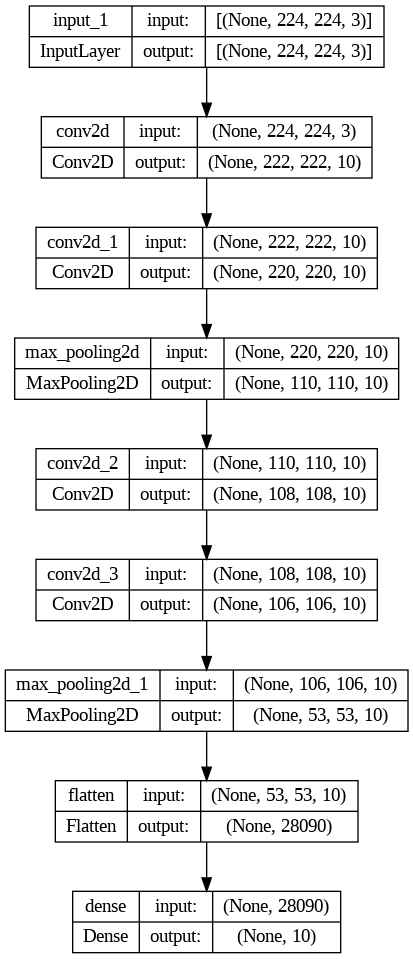

In [14]:
# visualizing the model structure
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

Now I will fit the model on the train data

In [15]:
history = model.fit(train_data,
                    epochs=5,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=0.25*len(test_data))

Epoch 1/5
235/235 [==============================] - 3583s 15s/step - loss: 2.2815 - accuracy: 0.1325 - val_loss: 2.2210 - val_accuracy: 0.1766
Epoch 2/5
235/235 [==============================] - 264s 1s/step - loss: 2.0626 - accuracy: 0.2580 - val_loss: 2.2210 - val_accuracy: 0.2047
Epoch 3/5
235/235 [==============================] - 202s 864ms/step - loss: 1.5761 - accuracy: 0.4601 - val_loss: 2.5024 - val_accuracy: 0.1672
Epoch 4/5
235/235 [==============================] - 161s 686ms/step - loss: 0.9612 - accuracy: 0.6772 - val_loss: 3.5932 - val_accuracy: 0.1625
Epoch 5/5
235/235 [==============================] - 129s 552ms/step - loss: 0.4238 - accuracy: 0.8659 - val_loss: 5.2127 - val_accuracy: 0.1500


The accuracy of the model on the validation dataset is only about 0.1 - 0.2

# Evaluating the model

In [16]:
model.evaluate(test_data)

79/79 [==============================] - 252s 3s/step - loss: 5.2708 - accuracy: 0.1540


[5.270815849304199, 0.15399999916553497]

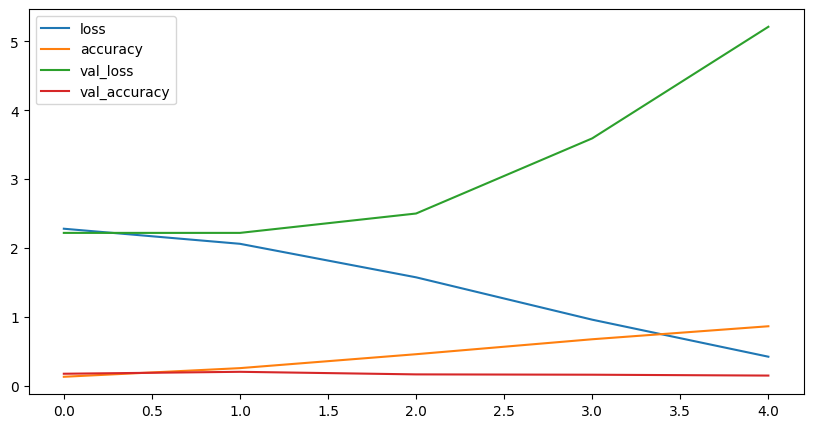

In [17]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10, 5));

It looks like the model significantly overfits.

# Fitting the model to a 10% subset

Training the model above took too much time, so in order to be able to perform experiments, try other models and fine-tune them I will download a subset of 10% of the data (10 classes). To do this I have used the function from [this file](). Since the test data remains unchanged I will upload only the train subset of the data.

In [18]:
train_dir_10p = "/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent"

In [19]:
for dirpath, dirnames, filenames in os.walk(train_dir_10p):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent'.
There are 10 directories and 0 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/donuts'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/hot_dog'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '/content/drive/MyDrive/Projects/food101/fast_food_10_classes_10_

In [20]:
# rescale the data
train_datagen_10p = ImageDataGenerator(rescale=1./255)

# load the data and create mini batches
train_data_10p = train_datagen_10p.flow_from_directory(train_dir_10p,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 750 images belonging to 1 classes.


To get a new baseline evaluation metrics I will clone the original model using `clone_model` without saving weights, fit it on the reduced data and then evaluate.

In [21]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.optimizers import Adam
model_1 = clone_model(model)

model_1.compile(loss="categorical_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

model_1.fit(train_data_10p,
            epochs=5,
            steps_per_epoch=len(train_data_10p),
            validation_data=test_data,
            validation_steps=0.25*len(test_data))

Epoch 1/5
24/24 [==============================] - 267s 11s/step - loss: 24.6031 - accuracy: 0.0013 - val_loss: 4.7960 - val_accuracy: 0.1141
Epoch 2/5
24/24 [==============================] - 5s 196ms/step - loss: 862.1637 - accuracy: 0.0453 - val_loss: 394.3857 - val_accuracy: 0.0969
Epoch 3/5
24/24 [==============================] - 5s 203ms/step - loss: 10153.2402 - accuracy: 0.1773 - val_loss: 2107.7576 - val_accuracy: 0.1063
Epoch 4/5
24/24 [==============================] - 5s 199ms/step - loss: 62817.1719 - accuracy: 0.0733 - val_loss: 12318.2510 - val_accuracy: 0.0938
Epoch 5/5
24/24 [==============================] - 5s 202ms/step - loss: 290226.7812 - accuracy: 0.0867 - val_loss: 52372.6445 - val_accuracy: 0.1000


In [22]:
model_1.evaluate(test_data)

79/79 [==============================] - 8s 101ms/step - loss: 51752.4297 - accuracy: 0.1020


[51752.4296875, 0.10199999809265137]

Now I will try to fit the model on the augmented data

In [23]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir_10p,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 750 images belonging to 1 classes.


In [24]:
model_2 = clone_model(model_1)

# Compile the cloned model (same setup as used for model_10)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data_augmented, # use augmented data
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
24/24 [==============================] - 19s 737ms/step - loss: 57.8399 - accuracy: 0.0000e+00 - val_loss: 21.1271 - val_accuracy: 0.0928
Epoch 2/5
24/24 [==============================] - 17s 737ms/step - loss: 1560.2220 - accuracy: 0.2267 - val_loss: 460.6397 - val_accuracy: 0.1068
Epoch 3/5
24/24 [==============================] - 17s 739ms/step - loss: 9381.4795 - accuracy: 0.0547 - val_loss: 2063.0820 - val_accuracy: 0.1048
Epoch 4/5
24/24 [==============================] - 18s 750ms/step - loss: 39483.1562 - accuracy: 0.0840 - val_loss: 11490.6104 - val_accuracy: 0.0940
Epoch 5/5
24/24 [==============================] - 18s 749ms/step - loss: 317775.5938 - accuracy: 0.0893 - val_loss: 82271.0938 - val_accuracy: 0.1068


In [25]:
model_2.evaluate(test_data)

79/79 [==============================] - 8s 102ms/step - loss: 82271.0781 - accuracy: 0.1068


[82271.078125, 0.10679999738931656]

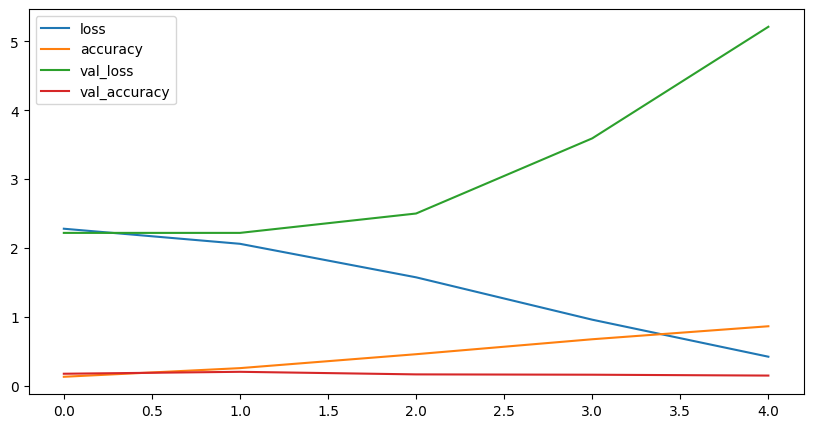

In [26]:
pd.DataFrame(history.history).plot(figsize=(10, 5));

# Fine-Tuning the model

Model still has pure perfomance. To reduce overfitting I will try to apply regularization (I will use L2 (Ridge regression) regularazation) and add Dropout and BatchNormalization layer. I will also try to add callbacs as learning rate scheduling (`ReduceLROnPlateau`) which adjusts the learning rate and early stopping callback. I will also train the model for a bigger amount of epochs.

First I will create the callbacks for a model

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                 patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


## Setting up mixed precision training

In [28]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [29]:
mixed_precision.global_policy()

<Policy "mixed_float16">

Now I will create the model, which has a simmilar structure to the original model, but now I will add: **Dropout, Batch Normalisation, Regulazier L2, Callbacks and different number of filters to Conv2D layers**

In [30]:
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import BatchNormalization, Dropout

input_layer = Input(shape = (224, 224, 3))

conv1 = Conv2D(16, 3, activation='relu', kernel_regularizer=L2(0.01))(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.2)(conv1)

conv2 = Conv2D(32, 3, activation='relu', kernel_regularizer=L2(0.01))(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.2)(conv2)

maxpool1 = MaxPooling2D()(conv2)

conv3 = Conv2D(64, 3, activation='relu', kernel_regularizer=L2(0.01))(conv2)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.2)(conv3)

conv4 = Conv2D(64, 3, activation='relu', kernel_regularizer=L2(0.01))(conv3)
conv4 = BatchNormalization()(conv4)
conv4 = Dropout(0.2)(conv4)

maxpool2 = MaxPooling2D()(conv4)

flatten = Flatten()(maxpool2)

dense1 = Dense(64, activation='relu')(flatten)
dense1 = Dropout(0.5)(dense1)

output_layer = Dense(10, activation='softmax')(dense1)

model_tuned = Model(inputs=input_layer, outputs=output_layer)


model_tuned.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001),
              metrics=["accuracy"])


In [31]:
for layer in model_tuned.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
conv2d_4 True float32 <Policy "mixed_float16">
batch_normalization True float32 <Policy "mixed_float16">
dropout True float32 <Policy "mixed_float16">
conv2d_5 True float32 <Policy "mixed_float16">
batch_normalization_1 True float32 <Policy "mixed_float16">
dropout_1 True float32 <Policy "mixed_float16">
conv2d_6 True float32 <Policy "mixed_float16">
batch_normalization_2 True float32 <Policy "mixed_float16">
dropout_2 True float32 <Policy "mixed_float16">
conv2d_7 True float32 <Policy "mixed_float16">
batch_normalization_3 True float32 <Policy "mixed_float16">
dropout_3 True float32 <Policy "mixed_float16">
max_pooling2d_3 True float32 <Policy "mixed_float16">
flatten_1 True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
dropout_4 True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">


In [32]:
history_tuned = model_tuned.fit(train_data_augmented,
                                epochs=20,
                                steps_per_epoch=len(train_data_augmented),
                                validation_data=test_data,
                                validation_steps=0.25*len(test_data),
                                callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
24/24 [==============================] - 18s 498ms/step - loss: inf - accuracy: 0.0840 - val_loss: 84.2174 - val_accuracy: 0.0844 - lr: 0.0010
Epoch 2/20
24/24 [==============================] - 12s 498ms/step - loss: nan - accuracy: 0.1320 - val_loss: 34.3722 - val_accuracy: 0.1375 - lr: 0.0010
Epoch 3/20
24/24 [==============================] - 12s 492ms/step - loss: nan - accuracy: 0.1893 - val_loss: 47.0206 - val_accuracy: 0.0906 - lr: 0.0010
Epoch 4/20
24/24 [==============================] - 12s 495ms/step - loss: nan - accuracy: 0.1880 - val_loss: 65.1769 - val_accuracy: 0.1312 - lr: 0.0010
Epoch 5/20
24/24 [==============================] - 12s 485ms/step - loss: nan - accuracy: 0.1787 - val_loss: 148.5332 - val_accuracy: 0.1266 - lr: 0.0010
Epoch 6/20
24/24 [==============================] - 12s 489ms/step - loss: nan - accuracy: 0.1973 - val_loss: 352.0748 - val_accuracy: 0.1063 - lr: 2.0000e-04
Epoch 7/20
24/24 [==============================] - 12s 490ms/step - l

In [33]:
model_tuned.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 16)      64        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 222, 222, 16)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                          

In [34]:
model_tuned.evaluate(test_data)

79/79 [==============================] - 8s 104ms/step - loss: 34.7733 - accuracy: 0.1116


[34.77325439453125, 0.11159999668598175]

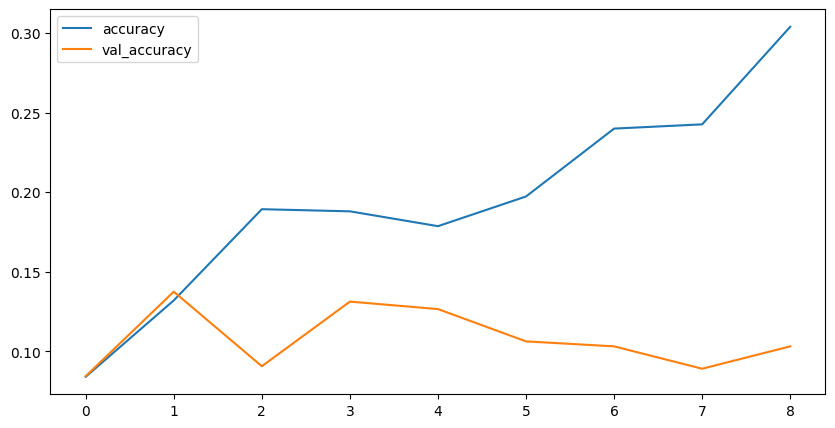

In [35]:
pd.DataFrame(history_tuned.history)[["accuracy", "val_accuracy"]].plot(figsize=(10, 5));

I tried to implement different methods to avoid overfitting and it didn't perfor well and the increase in performance is not sidnificant. The possible problem is a small amount of data, so now I will try to train the model above using the whole subset of 10 classes (with augmentation).

In [36]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_full_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 7500 images belonging to 10 classes.


In [37]:
model_tuned_full = clone_model(model_tuned)

model_tuned_full.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=["accuracy"])

history_tuned_full = model_tuned_full.fit(train_data_full_augmented,
                                          epochs=20,
                                          steps_per_epoch=len(train_data),
                                          validation_data=test_data,
                                          validation_steps=0.25*len(test_data),
                                          callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
235/235 [==============================] - 100s 417ms/step - loss: 21.8313 - accuracy: 0.0971 - val_loss: 664.4694 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 2/20
235/235 [==============================] - 97s 414ms/step - loss: 3.4155 - accuracy: 0.0976 - val_loss: 515.0164 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 3/20
235/235 [==============================] - 97s 412ms/step - loss: 3.2468 - accuracy: 0.0953 - val_loss: 369.5718 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 4/20
235/235 [==============================] - 97s 410ms/step - loss: 3.0817 - accuracy: 0.0948 - val_loss: 357.6625 - val_accuracy: 0.1109 - lr: 0.0010
Epoch 5/20
235/235 [==============================] - 98s 415ms/step - loss: 2.9305 - accuracy: 0.0931 - val_loss: 429.6960 - val_accuracy: 0.1047 - lr: 0.0010
Epoch 6/20
235/235 [==============================] - 98s 417ms/step - loss: 2.8000 - accuracy: 0.0915 - val_loss: 514.1266 - val_accuracy: 0.1078 - lr: 0.0010
Epoch 7/20
235/235 [==================

In [38]:
model_tuned_full.evaluate(test_data)

79/79 [==============================] - 8s 105ms/step - loss: 2.7514 - accuracy: 0.0996


[2.7513535022735596, 0.09960000216960907]

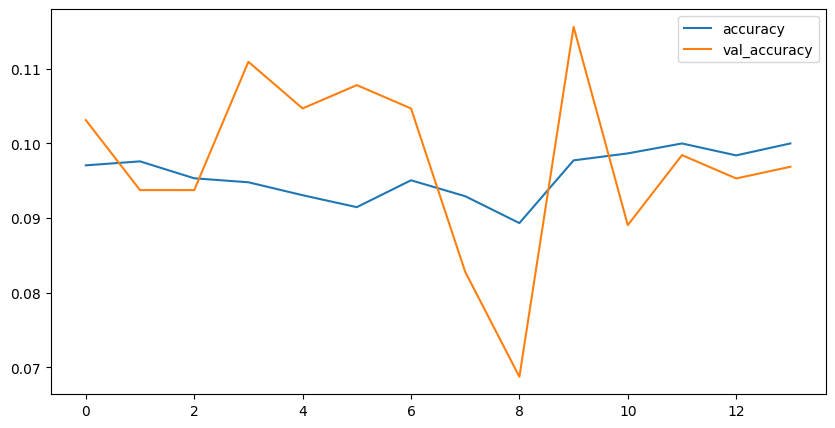

In [39]:
pd.DataFrame(history_tuned_full.history)[["accuracy", "val_accuracy",]].plot(figsize=(10, 5));

In the end even after augmenting the data and experimenting with model's architecture, it's perfomance got even worse than in the beginning with much simpliyer layer layout and withot data augmentation. As the result of these experiments I will take the value of accuracy on the validation set of the first model: *`0.15`* to compare with the results in the next project, where I will use transef learning and TensorFlow Hub models.